# Stillness in music and audience motion, Plots and test results\

This is a tidy version of analyses performed in the Testing_stillness notebooks, focused on the principal results.

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import pingouin as pg

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# import activity analysis functions from aa.py file in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport aa

In [3]:
%reload_ext autoreload

In [4]:
# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 

    data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

In [5]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / (fs/2)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [6]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [7]:
concert_times = pd.read_csv(public_time +'Events_Main.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [8]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


concert_times = pd.read_csv(public_time +'Events_Full.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format
concert_times['sequence'] = concert_times.index
concert_times.set_index('Datetime',inplace = True)
#concert_times.iloc[50:75]

In [9]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['A']),:] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
#alignedParts

In [10]:
tic = time.time()
# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000

for i,participant in alignedParts.iterrows():
    part = participant['Participant_Code']
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
#         f = interpolate.interp1d(datas['time'], datas[col],fill_value= 'previous')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
        aud_df[part] = b.copy()*6 
    else:
        aud_df[part] = b.copy()
        
aud_df.index = dt_ct
# ori_aud_df = aud_df.copy()
# ori_aud_df.index = (ts_ct/1000).round(1)

print(time.time()-tic)

80.79168009757996


In [24]:
Event_ranges = {'Beethoven 1':[8,9],'Beethoven 2':[9,10],'Beethoven 3':[10,11],'Beethoven 4':[11,12],'Schnittke 1':[17,18],'Schnittke 2':[18,19],'Schnittke 3':[19,20],'Bach':[28,29],'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}
Seg_ranges = {'Beethoven':[8,12],'Schnittke':[17,20],'Bach':[28,29],'Folk':[33,51]}

aud_df.index = (ts_ct/1000).round(1)


In [12]:
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[51,0]
[seg_start,seg_end ]

[57.4, 8042.24]

In [13]:
seg_df = aud_df.loc[seg_start:seg_end].copy()
seg_df = seg_df.fillna(0)

In [32]:
Stillings = pd.read_csv('./data/' + 'Low_Stillings_with_Audio.csv')
Stillings=Stillings.fillna(0)
Stillings= Stillings.set_index('TIME')
# add music column
Stillings['Music'] = 'Music'
for ev in Seg_ranges.keys():
    seg_start = Main_concert_times.iloc[Seg_ranges[ev][0],0]
    seg_end = Main_concert_times.iloc[Seg_ranges[ev][1],0]
    Stillings.loc[seg_start:seg_end,'Music'] = ev

seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[51,0]
[seg_start,seg_end ]
Still_times  = Stillings.loc[seg_start:seg_end].copy()
print(len(Still_times))
Still_times.iloc[:5,:]

247


,LABEL,Set,Movement,Moment,Since,Type,end,Sequence,Rest,Gap,...,OnsetRate_pre,OnsetRate_post,OnsetRate_shift,QoMmean_pre,QoMmean_post,QoMmean_shift,QoMmedian_pre,QoMmedian_post,QoMmedian_shift,Music
TIME,,,,,,,,,,,,,,,,,,,,,
61.320000,2.5,1,1,1,3.90,Rest,0.0,0.0,1,0,...,0.184,0.068,-0.116,0.089556,0.103294,0.013737,0.065307,0.075057,0.009750,Beethoven
65.837000,4.5,1,1,2,4.52,Rest_beat,0.0,0.0,1,0,...,0.228,0.164,-0.064,0.093719,0.076876,-0.016842,0.065231,0.061526,-0.003705,Beethoven
79.016000,10.25,1,1,3,13.18,Rest_beat,0.0,0.0,1,0,...,0.488,0.076,-0.412,0.095983,0.080000,-0.015983,0.071701,0.066231,-0.005470,Beethoven
88.746667,13,1,1,4,9.24,Low_onset,0.0,0.0,0,0,...,0.172,0.140,-0.032,0.084274,0.074454,-0.009820,0.067403,0.065510,-0.001893,Beethoven
96.042667,17 x,1,1,5,6.55,Low_onset,0.0,0.0,0,0,...,0.500,0.400,-0.100,0.072141,0.081867,0.009726,0.061173,0.066505,0.005331,Beethoven


In [29]:
Stillings.columns

Index(['LABEL', 'Set', 'Movement', 'Moment', 'Since', 'Type', 'end',
       'Sequence', 'Rest', 'Gap', 'Connect', 'Elide', 'Phr_end',
       'Phr_begining', 'Rubato', 'Rit', 'Fermata', 'Precision', 'Cresc', 'Fp',
       'Diminuendo', 'TextDec', 'Drone', 'TextInc', 'revisedT', 'old_TIME',
       'old_Ratio', 'Ratio', 'SoundAmp_pre', 'SoundAmp_post', 'SoundAmp_shift',
       'OnsetRate_pre', 'OnsetRate_post', 'OnsetRate_shift', 'QoMmean_pre',
       'QoMmean_post', 'QoMmean_shift', 'QoMmedian_pre', 'QoMmedian_post',
       'QoMmedian_shift', 'Music'],
      dtype='object')

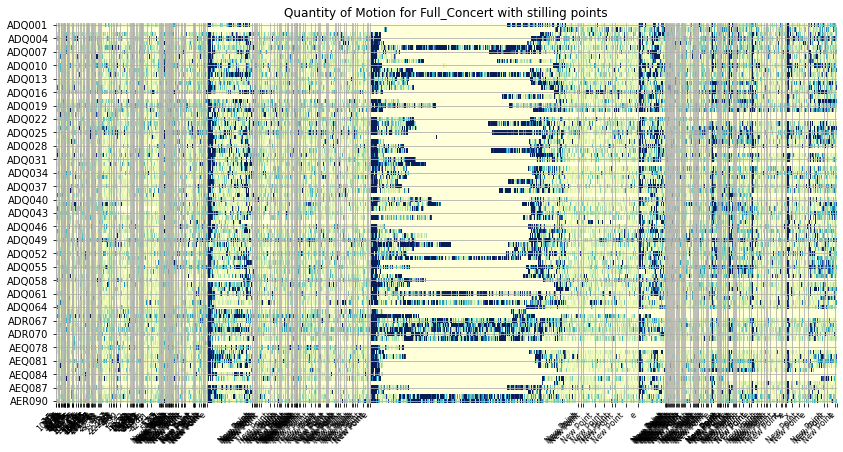

In [15]:
fig, (ax1) = plt.subplots(1, 1,figsize = [14,7])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu")
new_xticks = len(seg_df)*(Still_times.index - seg_start)/(seg_end-seg_start)
plt.xticks(new_xticks,Still_times['LABEL'], rotation='45',fontsize=8, ha='right')
plt.grid()
plt.title('Quantity of Motion for ' + seg_tag + ' with stilling points')
plt.savefig('./Plots/Hall_qom_stillingpoints.png',dpi = 300)
plt.show()

## First test: How do stilling points selected compare to random points during music
Evaluation in form of ratio of participants decreasing

Decreases are not qualified with a threshold, thus mixing together small shifts and large ones. This is a choice as the amount of motion is already quite low for many of these pieces, and we can avoid some noise in the measurements. 

In [46]:
preoff = -3
postoff = -0.2 # Easier to explain if I use zero. /:

In [47]:
#fig,ax = plt.subplots(1,1,figsize=[14,4] )
V = pd.DataFrame(columns = seg_df.columns)
k = []
for i in range(len(Still_times)):
    sm = Still_times.iloc[i,:]
    Otime = sm.name
    pre_snip_df = seg_df.loc[Otime+preoff:Otime+preoff+1.0].mean(axis=0).values
    post_snip_df = seg_df.loc[Otime+postoff:Otime+postoff+1.0].mean(axis=0).values
    V.loc[Otime,:] = post_snip_df-pre_snip_df
    k.append(sum((post_snip_df-pre_snip_df)<0)/len(pre_snip_df))

# V.plot(legend=False,ax=ax)
# V.mean(axis=1).plot(ax=ax,color='k',linewidth=2)
# plt.xticks(Still_times.index,Still_times.LABEL, rotation='45',fontsize=8, ha='right')
# print([V.mean(axis=1).median(),V.mean(axis=1).sem()])
# plt.ylim([-0.1,0.1])
# plt.grid()
# plt.show()
print([np.median(np.array(k)),np.std(np.array(k))])

[0.5058823529411764, 0.06865807699683658]


In [48]:
Still_times['Ratio'] = k

In [49]:
Event_ranges = {'Beethoven':[8,12],'Schnittke':[17,20],'Bach':[28,29],'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}
mov_df = pd.DataFrame(columns = seg_df.columns,index=Event_ranges.keys())
seg_df = aud_df.copy()
mus_df = pd.DataFrame(columns = seg_df.columns)

#seg_df = seg_df.fillna(0)
for ev in Event_ranges:
#     print(ev)
    seg_start = Main_concert_times.iloc[Event_ranges[ev][0],0]
    seg_end = Main_concert_times.iloc[Event_ranges[ev][1],0]
    mov_df.loc[ev,:] = seg_df.loc[seg_start:seg_end,:].copy().mean(skipna=True)
    mus_df  = pd.concat([mus_df,seg_df.loc[seg_start:seg_end,:].copy()])
music_index = mus_df.index
# mov_df


In [61]:
len(music_index)

50630

In [50]:
# evaluate all moments during music for decreasing as defined
V_df = pd.DataFrame(index = music_index)
seg_df = aud_df.copy()
seg_df = seg_df.fillna(0)
k=[]
for i in music_index:
    pre_snip_df = seg_df.loc[i+preoff:i+preoff+1.0].mean(axis=0).values
    post_snip_df = seg_df.loc[i+postoff:i+postoff+1].mean(axis=0).values
    k.append(sum((post_snip_df-pre_snip_df)<0)/len(pre_snip_df))
V_df['Ratio'] = k

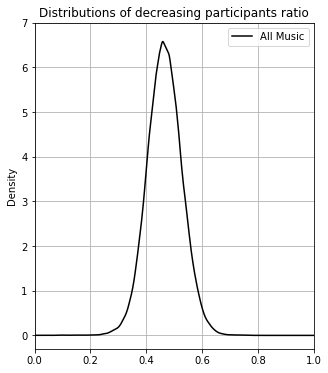

In [392]:
V_df.loc[:,'Ratio'].plot.kde(label='All Music',color='k',figsize=[5,6])
#Still_times.loc[:,'Ratio'].plot.kde(label='Stilling Points')
plt.legend()
plt.title('Distributions of decreasing participants ratio')
plt.grid()
#Part_Still.loc[:,'Ratio'].plot.kde()
plt.xlim([0,1])
plt.ylim([-0.3,7])
#plt.savefig('./Plots/All_Stillings_part_ratios_dke.png',dpi = 300)
plt.savefig('./Plots/All_Music_part_ratios_dke.png',dpi = 300)

plt.show()

In [57]:
print([Still_times.loc[:,'Ratio'].median(),V_df.loc[:,'Ratio'].median()])
sp.stats.ks_2samp(Still_times.loc[:,'Ratio'], V_df.loc[:,'Ratio'], alternative='less')

[0.5058823529411764, 0.47058823529411764]


KstestResult(statistic=0.2205504569549186, pvalue=3.55356233194559e-11)

In [67]:
np.arange(0,1,0.05)
music_index[np.arange(1,50630,40)]

Float64Index([  57.5,   97.5,  137.5,  177.5,  217.5,  257.5,  297.5,  337.5,
               377.5,  417.5,
              ...
              7533.0, 7602.6, 7642.6, 7682.6, 7722.6, 7859.4, 7899.4, 7939.4,
              7979.4, 8019.4],
             dtype='float64', length=127)

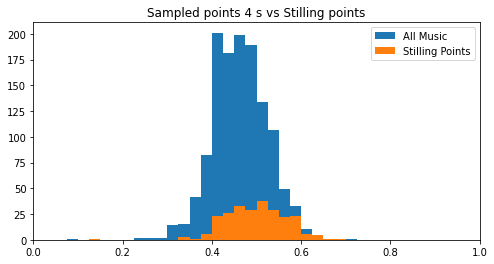

In [150]:
V_df.loc[music_index[np.arange(1,50630,40)],'Ratio'].hist(bins = np.arange(0,1,0.025),label='All Music',figsize=[8,4])
Still_times.loc[:,'Ratio'].hist(bins = np.arange(0,1,0.025),label='Stilling Points')
plt.legend()
plt.title('Sampled points 4 s vs Stilling points')
plt.grid()
#Part_Still.loc[:,'Ratio'].plot.kde()
plt.xlim([0,1])
plt.savefig('./Plots/All4s_Stillings_part_ratios_hist.png',dpi = 300)
plt.show()

In [57]:
print([Still_times.loc[:,'Ratio'].median(),V_df.loc[music_index[np.arange(1,50630,40)],'Ratio'].median()])
sp.stats.ks_2samp(Still_times.loc[:,'Ratio'], V_df.loc[music_index[np.arange(1,50630,40)],'Ratio'], alternative='less')

[0.5058823529411764, 0.47058823529411764]


KstestResult(statistic=0.2205504569549186, pvalue=3.55356233194559e-11)

## Strong stilling points

Evaluate the characteristics of those time points that show higher rates of concurrent stillness vs the whole set initially collected. What qualities or tags coincide with stillness? 

In [214]:
mean_dec = 0.47058823529411764 #V_df ,mean
Part_Still = Still_times.loc[Still_times['Ratio']>mean_dec,:]
Part_Still = Still_times.loc[Still_times['Ratio']>0.5,:]

# Part_Still = Still_times.loc[~Still_times['LABEL'].isin(['e']),:] # in person hall participant
# Part_Still = Part_Still.loc[Part_Still['Ratio']>mean_dec,:]
#Part_Still = Part_Still.loc[~Part_Still['LABEL'].isin(['e-1']),:] # in person hall participant
#Part_Still = Part_Still.loc[Part_Still['Gap']>0,:].reset_index(drop = True) # with aligned motion measurements
print(len(Part_Still)/len(Still_times))

0.5060728744939271


In [215]:
Part_Still['LABEL'].to_csv('Stillers0p5.csv')

In [216]:
print(len(Part_Still))
Part_Still.columns

125


Index(['LABEL', 'Set', 'Movement', 'Moment', 'Since', 'Type', 'end',
       'Sequence', 'Rest', 'Gap', 'Connect', 'Elide', 'Phr_end',
       'Phr_begining', 'Rubato', 'Rit', 'Fermata', 'Precision', 'Cresc', 'Fp',
       'Diminuendo', 'TextDec', 'Drone', 'TextInc', 'revisedT', 'old_TIME',
       'old_Ratio', 'Ratio', 'SoundAmp_pre', 'SoundAmp_post', 'SoundAmp_shift',
       'OnsetRate_pre', 'OnsetRate_post', 'OnsetRate_shift', 'QoMmean_pre',
       'QoMmean_post', 'QoMmean_shift', 'QoMmedian_pre', 'QoMmedian_post',
       'QoMmedian_shift', 'Music'],
      dtype='object')

In [217]:
Feat_stats = pd.DataFrame(index = Part_Still.columns)

In [286]:
A = Still_times[['end',
       'Sequence', 'Rest', 'Gap', 'Connect', 'Elide', 'Phr_end',
       'Phr_begining', 'Rubato', 'Rit', 'Fermata', 'Precision', 'Cresc', 'Fp',
       'Diminuendo', 'TextDec', 'Drone', 'TextInc', 'revisedT']].sum()
Feat_stats.loc[A.index,"Stillings"] = A

A = Still_times[['old_Ratio', 'Ratio', 'SoundAmp_pre', 'SoundAmp_post', 'SoundAmp_shift',
       'OnsetRate_pre', 'OnsetRate_post', 'OnsetRate_shift', 'QoMmean_pre',
       'QoMmean_post', 'QoMmean_shift', 'QoMmedian_pre', 'QoMmedian_post',
       'QoMmedian_shift']].mean()
Feat_stats.loc[A.index,"Stillings"] = A

A = Part_Still[['end','Sequence', 'Rest', 'Gap', 'Connect', 'Elide', 'Phr_end',
       'Phr_begining', 'Rubato', 'Rit', 'Fermata', 'Precision', 'Cresc', 'Fp',
       'Diminuendo', 'TextDec', 'Drone', 'TextInc', 'revisedT']].sum()
Feat_stats.loc[A.index,"Stillers"] = A

A = Part_Still[['old_Ratio', 'Ratio', 'SoundAmp_pre', 'SoundAmp_post', 'SoundAmp_shift',
       'OnsetRate_pre', 'OnsetRate_post', 'OnsetRate_shift', 'QoMmean_pre',
       'QoMmean_post', 'QoMmean_shift', 'QoMmedian_pre', 'QoMmedian_post',
       'QoMmedian_shift']].mean()
Feat_stats.loc[A.index,"Stillers"] = A

A = Mixed_Still[['end','Sequence', 'Rest', 'Gap', 'Connect', 'Elide', 'Phr_end',
       'Phr_begining', 'Rubato', 'Rit', 'Fermata', 'Precision', 'Cresc', 'Fp',
       'Diminuendo', 'TextDec', 'Drone', 'TextInc', 'revisedT']].sum()
Feat_stats.loc[A.index,"Mixed"] = A

A = Mixed_Still[['old_Ratio', 'Ratio', 'SoundAmp_pre', 'SoundAmp_post', 'SoundAmp_shift',
       'OnsetRate_pre', 'OnsetRate_post', 'OnsetRate_shift', 'QoMmean_pre',
       'QoMmean_post', 'QoMmean_shift', 'QoMmedian_pre', 'QoMmedian_post',
       'QoMmedian_shift']].mean()
Feat_stats.loc[A.index,"Mixed"] = A

Feat_stats.loc["Precision",:] = Feat_stats.loc["Precision",:]/2
Feat_stats['R_stilled'] = Feat_stats.loc[:,"Stillers"]/Feat_stats.loc[:,"Stillings"]
Feat_stats['R_Mixed'] = Feat_stats.loc[:,"Mixed"]/Feat_stats.loc[:,"Stillings"]

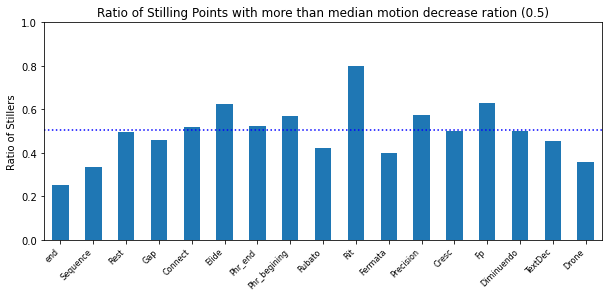

In [292]:
feats_set = ['end','Sequence', 'Rest', 'Gap', 'Connect', 'Elide', 'Phr_end',
       'Phr_begining', 'Rubato', 'Rit', 'Fermata', 'Precision', 'Cresc', 'Fp',
       'Diminuendo', 'TextDec', 'Drone']
Feat_stats.loc[feats_set,'R_stilled'].plot.bar(figsize=(10,4))
plt.xticks(np.arange(len(feats_set)),feats_set,rotation='45',fontsize=8, ha='right')
plt.plot([-1,len(feats_set)],[len(Part_Still)/len(Still_times),len(Part_Still)/len(Still_times)],':b')
plt.xlim([-0.5,len(feats_set)-0.5])
plt.ylim([0,1])
plt.ylabel('Ratio of Stillers')
plt.title('Ratio of Stilling Points with more than median motion decrease ration (0.5)')
plt.savefig('./Plots/Tags_Stillers_Ratio.png',dpi = 300)

plt.show()

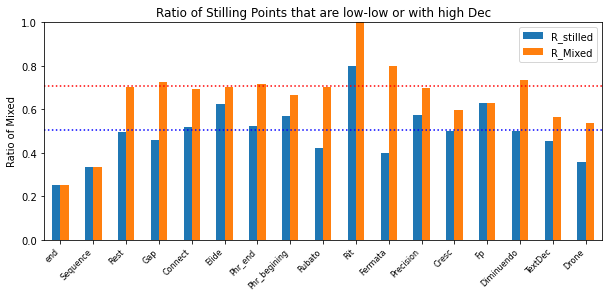

In [294]:
feats_set = ['end','Sequence', 'Rest', 'Gap', 'Connect', 'Elide', 'Phr_end',
       'Phr_begining', 'Rubato', 'Rit', 'Fermata', 'Precision', 'Cresc', 'Fp',
       'Diminuendo', 'TextDec', 'Drone']
Feat_stats.loc[feats_set,['R_stilled','R_Mixed']].plot.bar(figsize=(10,4))
plt.xticks(np.arange(len(feats_set)),feats_set,rotation='45',fontsize=8, ha='right')
plt.plot([-1,len(feats_set)],[len(Part_Still)/len(Still_times),len(Part_Still)/len(Still_times)],':b')
plt.plot([-1,len(feats_set)],[len(Mixed_Still)/len(Still_times),len(Mixed_Still)/len(Still_times)],':r')
plt.xlim([-0.5,len(feats_set)-0.5])
plt.ylim([0,1])
plt.ylabel('Ratio of Mixed')
plt.title('Ratio of Stilling Points that are low-low or with high Dec')
plt.savefig('./Plots/Tags_Mixed_Ratio.png',dpi = 300)

plt.show()

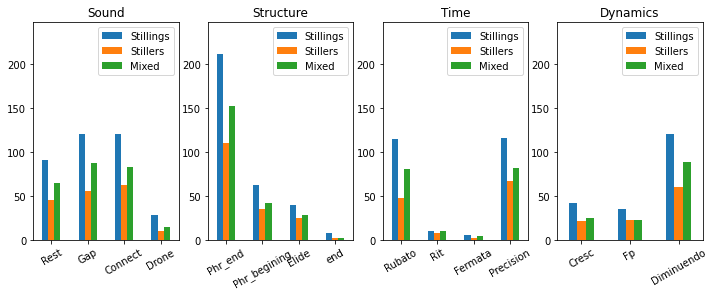

In [290]:
feats_set = ['end','Sequence', 'Rest', 'Gap', 'Connect', 'Elide', 'Phr_end',
       'Phr_begining', 'Rubato', 'Rit', 'Fermata', 'Precision', 'Cresc', 'Fp',
       'Diminuendo', 'TextDec', 'Drone','revisedT']

f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(12,4))
ax = ax1
feats_set = ['Rest', 'Gap', 'Connect', 'Drone']
Feat_stats.loc[feats_set,["Stillings","Stillers","Mixed"]].plot.bar(ax = ax)
ax.set_title('Sound')
ax.set_xlim([-0.5,len(feats_set)-0.5])
ax.set_ylim([0,247])
ax.tick_params(axis='x',labelrotation=30)

ax = ax2
feats_set = [ 'Phr_end','Phr_begining','Elide', 'end']
Feat_stats.loc[feats_set,["Stillings","Stillers","Mixed"]].plot.bar(ax = ax)
ax.set_title('Structure')
ax.set_xlim([-0.5,len(feats_set)-0.5])
ax.set_ylim([0,247])
ax.tick_params(axis='x',labelrotation=30)

ax = ax3
feats_set = ['Rubato', 'Rit', 'Fermata','Precision']
Feat_stats.loc[feats_set,["Stillings","Stillers","Mixed"]].plot.bar(ax = ax)
ax.set_title('Time')
ax.set_xlim([-0.5,len(feats_set)-0.5])
ax.set_ylim([0,247])
ax.tick_params(axis='x',labelrotation=30)

ax = ax4
feats_set = ['Cresc', 'Fp','Diminuendo']
Feat_stats.loc[feats_set,["Stillings","Stillers","Mixed"]].plot.bar(ax = ax)
ax.set_title('Dynamics')
ax.legend(loc="best")
ax.set_xlim([-0.5,len(feats_set)-0.5])
ax.set_ylim([0,247])
ax.tick_params(axis='x',labelrotation=30)

plt.savefig('./Plots/Tags_Mixed_Ratio_sep.png',dpi = 300)

plt.show()

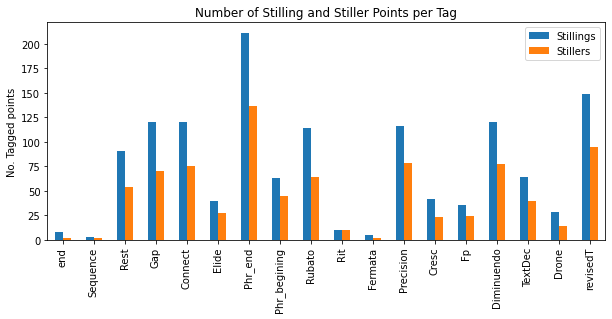

In [191]:
feats_set = ['end','Sequence', 'Rest', 'Gap', 'Connect', 'Elide', 'Phr_end',
       'Phr_begining', 'Rubato', 'Rit', 'Fermata', 'Precision', 'Cresc', 'Fp',
       'Diminuendo', 'TextDec', 'Drone','revisedT']
Feat_stats.loc[feats_set,["Stillings","Stillers"]].plot.bar(figsize=(10,4))
plt.ylabel('No. Tagged points')
plt.title('Number of Stilling and Stiller Points per Tag')
plt.savefig('./Plots/All4s_Stillings_part_ratios_hist.png',dpi = 300)

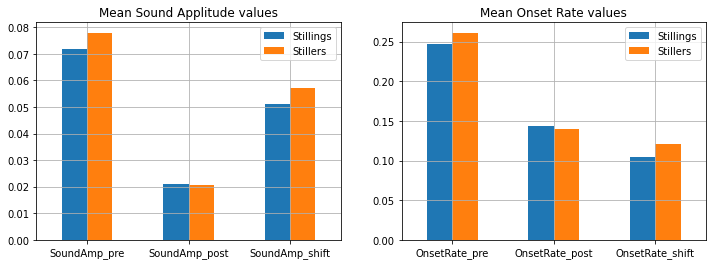

In [197]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

feats_set = ['SoundAmp_pre', 'SoundAmp_post', 'SoundAmp_shift']
Feat_stats.loc[feats_set,["Stillings","Stillers"]].abs().plot.bar(ax = ax1)
ax1.set_title('Mean Sound Applitude values')
ax1.legend(loc="best")
ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)

feats_set = ['OnsetRate_pre', 'OnsetRate_post', 'OnsetRate_shift']
Feat_stats.loc[feats_set,["Stillings","Stillers"]].abs().plot.bar(ax = ax2)
ax2.set_title('Mean Onset Rate values')
ax2.grid()
ax2.tick_params(axis='x',labelrotation=0)

plt.savefig('./Plots/Sound_feats_Stillings.png',dpi = 300)
plt.show()


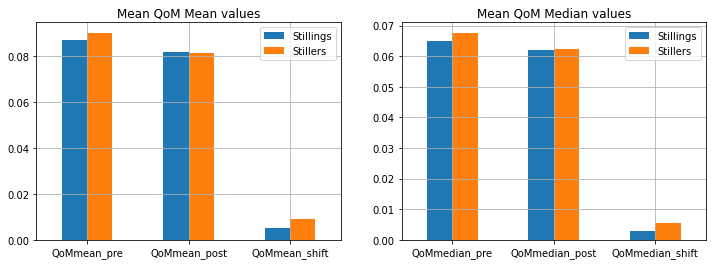

In [196]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

feats_set = ['QoMmean_pre','QoMmean_post', 'QoMmean_shift']
Feat_stats.loc[feats_set,["Stillings","Stillers"]].abs().plot.bar(ax = ax1)
ax1.set_title('Mean QoM Mean values')
ax1.legend(loc="best")
ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)

feats_set = ['QoMmedian_pre', 'QoMmedian_post','QoMmedian_shift']
Feat_stats.loc[feats_set,["Stillings","Stillers"]].abs().plot.bar(ax = ax2)
ax2.set_title('Mean QoM Median values')
ax2.grid()
ax2.tick_params(axis='x',labelrotation=0)

plt.savefig('./Plots/QoM_feats_Stillings.png',dpi = 300)
plt.show()


In [193]:
Stills_Pieces = pd.DataFrame()
Stills_Pieces['Stillings'] =Still_times['Music'].value_counts()
Stills_Pieces['Stillers'] = Part_Still['Music'].value_counts()
Stills_Pieces['R_stilled'] = Stills_Pieces.loc[:,"Stillers"]/Stills_Pieces.loc[:,"Stillings"]
Stills_Pieces

,Stillings,Stillers,R_stilled
Beethoven,112,79,0.705357
Folk,73,42,0.575342
Schnittke,53,28,0.528302
Bach,9,5,0.555556


### timing of stillness
Look at the profile of mean motion across participants at those moments of noticeable stillness. How are they 

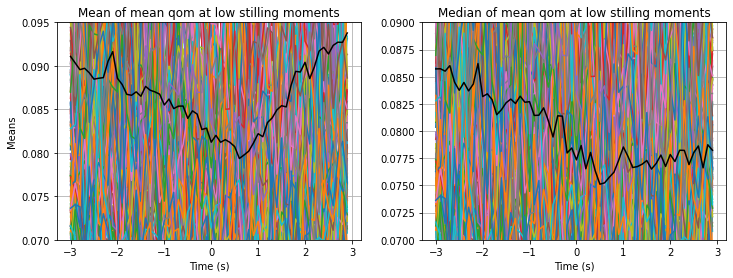

In [194]:
Part_times = Part_Still.copy()
#Part_times = Still_times.copy()
# extract the distribution of average movement in some seconds before each still time and in/after
meanQM = seg_df.mean(axis=1)

snips = pd.DataFrame(index = np.arange(-3,3, 0.1),columns = Part_times.index)

for i in range(len(Part_times)-1):
    sm = Part_times.iloc[i,:]
    Otime = sm.name
    snips.loc[:,Otime]=meanQM.loc[Otime-3.025:Otime+2.975].values
    
    
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

ax=ax1
snips.plot(legend = False,ax=ax)
snips.mean(axis=1).plot(color = 'k',legend = False,ax=ax)
ax.set_title('Mean of mean qom at low stilling moments')
ax.set_ylim([0.07,0.095])
ax.set_ylabel('Means')
ax.set_xlabel('Time (s)')
ax.grid()

ax=ax2
snips.plot(legend = False,ax=ax)
snips.median(axis=1).plot(color = 'k',legend = False,ax=ax)
ax.set_title('Median of mean qom at low stilling moments')
ax.set_ylim([0.070,0.09])
ax.set_xlabel('Time (s)')
ax.grid()

plt.savefig('./Plots/Stiller_QoM_Means_with_ends.png',dpi = 300)

plt.show()


In [345]:
Main_concert_times

,Time_s,Time_ms,Event,Event_Type,Time_Stream,Event_Duration,sequence
Datetime,,,,,,,
2021-10-26 17:36:35,-691.24,-691240,Clapping for MC,Applause,946.00,18.12,0
2021-10-26 17:36:53,-673.12,-673120,Speech,Speech,964.12,117.08,1
2021-10-26 17:38:50,-556.04,-556040,Clapping for MC,Applause,1081.20,5.88,2
2021-10-26 17:38:56,-550.16,-550160,Speech,Speech,1087.08,380.52,3
2021-10-26 17:45:16,-169.64,-169640,Clapping for MC,Applause,1467.60,105.96,4
2021-10-26 17:47:02,-63.68,-63680,Speech,Speech,1573.56,63.68,5
2021-10-26 17:48:06,0.00,0,Taps 1,Synchronisation,1637.24,14.38,6
2021-10-26 17:48:20,14.38,14380,Clapping for Musicians,Applause,1651.62,43.02,7
2021-10-26 17:49:03,57.40,57400,Beethoven 1,Music,1694.64,418.68,8


In [349]:
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[5,0]
seg_end = Main_concert_times.iloc[53,0]
seg_times = Main_concert_times.loc[Main_concert_times['Event_Type'].isin(['Music']),:]
[seg_start,seg_end ]
seg_df = aud_df.loc[seg_start:seg_end].copy()
seg_df = seg_df.fillna(0)

,Time_s,Time_ms,Event,Event_Type,Time_Stream,Event_Duration,sequence
Datetime,,,,,,,
2021-10-26 17:49:03,57.40,57400,Beethoven 1,Music,1694.64,418.68,8
2021-10-26 17:56:02,476.08,476080,Beethoven 2,Music,2113.32,225.10,9
2021-10-26 17:59:47,701.18,701180,Beethoven 3,Music,2338.42,468.98,10
2021-10-26 18:07:36,1170.16,1170160,Beethoven 4,Music,2807.40,440.20,11
2021-10-26 18:22:20,2054.48,2054480,Schnittke 1,Music,3691.72,364.28,17
2021-10-26 18:28:25,2418.76,2418760,Schnittke 2,Music,4056.00,336.52,18
2021-10-26 18:34:01,2755.28,2755280,Schnittke 3,Music,4392.52,527.08,19
2021-10-26 19:16:00,5274.36,5274360,Bach,Music,6911.60,745.08,28
2021-10-26 19:32:37,6271.28,6271280,Folk 1,Music,7908.52,487.68,33


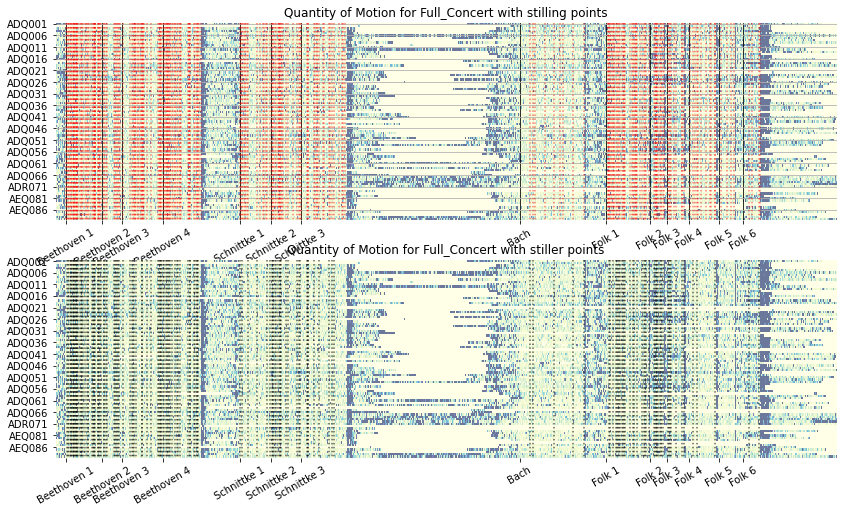

In [363]:
fig, (ax1,ax2) = plt.subplots(2, 1,figsize = [14,8])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu",alpha=0.6)
new_xticks = len(seg_df)*(Still_times.index - seg_start)/(seg_end-seg_start)
#ax1.set_xticks(new_xticks)

for i in range(len(new_xticks)):
    ax1.plot([new_xticks[i],new_xticks[i]],[0,90],':r',alpha=0.5)

ax1.set_title('Quantity of Motion for ' + seg_tag + ' with stilling points')
Music_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end-seg_start)
ax1.set_xticks(Music_xticks)
ax1.set_xticklabels(seg_times.Event)
ax1.tick_params(axis='x',grid_color='k',labelrotation=30)
ax1.grid()


chart = sns.heatmap(data=seg_df.transpose(), ax=ax2,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu",alpha=0.6)

# new_xticks = len(seg_df)*(Mixed_Still.index - seg_start)/(seg_end-seg_start)
# for i in range(len(new_xticks)):
#     ax2.plot([new_xticks[i],new_xticks[i]],[0,90],':r',alpha=0.5)
    
new_xticks = len(seg_df)*(Part_times.index - seg_start)/(seg_end-seg_start)
for i in range(len(new_xticks)):
    ax2.plot([new_xticks[i],new_xticks[i]],[0,90],':k',alpha=0.6)

ax2.grid()
ax2.set_title('Quantity of Motion for ' + seg_tag + ' with stiller points')
#ax2.set_title('Quantity of Motion for ' + seg_tag + ' with stiller and Low-low points')
ax2.set_xticks(Music_xticks)
ax2.set_xticklabels(seg_times.Event)
ax2.tick_params(axis='x',grid_color='k',labelrotation=30)
ax2.grid()
plt.savefig('./Plots/Hall_qom_More_stilledpoints.png',dpi = 300)
#plt.savefig('./Plots/Hall_qom_Mixed_stillpoints.png',dpi = 300)
plt.show()

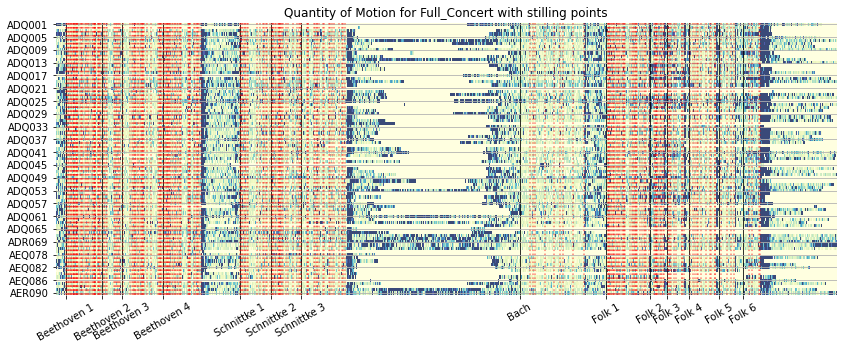

In [360]:
fig, (ax1) = plt.subplots(1, 1,figsize = [14,5])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu",alpha=0.8)
new_xticks = len(seg_df)*(Still_times.index - seg_start)/(seg_end-seg_start)
#ax1.set_xticks(new_xticks)

for i in range(len(new_xticks)):
    ax1.plot([new_xticks[i],new_xticks[i]],[0,90],':r',alpha=0.5)

ax1.set_title('Quantity of Motion for ' + seg_tag + ' with stilling points')
Music_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end-seg_start)
ax1.set_xticks(Music_xticks)
ax1.set_xticklabels(seg_times.Event)
ax1.tick_params(axis='x',grid_color='k',labelrotation=30)
ax1.grid()

plt.savefig('./Plots/Hall_qom_stillingpoints.png',dpi = 300)
plt.show()

In [333]:
i = 1

new_xticks[i]

216.1616242780069

In [329]:
print(chart.axes)

AxesSubplot(0.125,0.125;0.775x0.343182)


In [210]:
Part_Still

,LABEL,Set,Movement,Moment,Since,Type,end,Sequence,Rest,Gap,...,OnsetRate_pre,OnsetRate_post,OnsetRate_shift,QoMmean_pre,QoMmean_post,QoMmean_shift,QoMmedian_pre,QoMmedian_post,QoMmedian_shift,Music
TIME,,,,,,,,,,,,,,,,,,,,,
65.837000,4.5,1,1,2,4.52,Rest_beat,0.0,0.0,1,0,...,0.228,0.164,-0.064,0.093719,0.076876,-0.016842,0.065231,0.061526,-0.003705,Beethoven
79.016000,10.25,1,1,3,13.18,Rest_beat,0.0,0.0,1,0,...,0.488,0.076,-0.412,0.095983,0.080000,-0.015983,0.071701,0.066231,-0.005470,Beethoven
88.746667,13,1,1,4,9.24,Low_onset,0.0,0.0,0,0,...,0.172,0.140,-0.032,0.084274,0.074454,-0.009820,0.067403,0.065510,-0.001893,Beethoven
111.573333,25.5,1,1,6,16.28,Low_onset,0.0,0.0,0,0,...,0.408,0.168,-0.240,0.096341,0.082787,-0.013554,0.071862,0.065035,-0.006827,Beethoven
115.285333,27.5,1,1,7,3.70,2nd in sequence,0.0,1.0,0,0,...,0.240,0.232,-0.008,0.078753,0.085918,0.007165,0.060767,0.064161,0.003394,Beethoven
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7263.520000,New Point,7,1,230,33.08,Low_Rest,0.0,0.0,1,1,...,0.052,0.000,-0.052,0.070824,0.056623,-0.014202,0.049408,0.047079,-0.002329,Folk
7315.430000,New Point,7,1,232,18.26,Low_Rest,0.0,0.0,0,0,...,0.000,0.112,0.112,0.071567,0.065147,-0.006420,0.055271,0.049437,-0.005833,Folk
7527.613333,e,7,1,239,8.27,Low_Rest,0.0,0.0,1,1,...,0.012,0.000,-0.012,0.064628,0.067973,0.003345,0.049775,0.044851,-0.004924,Folk


In [213]:
Part_Still['LABEL'].to_csv('Stillers.csv')

In [ ]:
# Demonstration set
# last two minutes of Beethove: 1460s to 1600s concert time


## Stilling vs Already still
Review of the strong stilling points against the music shows that a lot of the points expected to produce stilling that didn't show a majority of participants decreasing in their movement are at moments where the music is already extremely quiet, i.e. where the audience would already by extremely still. 

We need some way of recognising this situation along side the 3 s decrease in motion. This involves establishing a threshold for how still the audience must be to already be too still. 

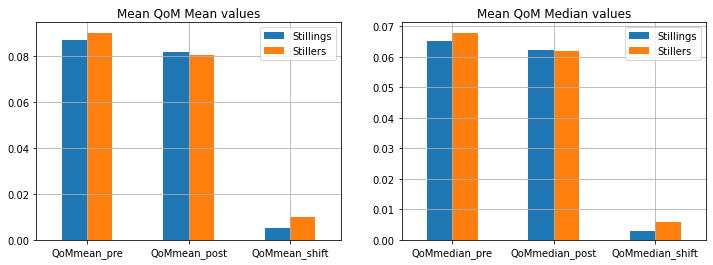

In [221]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

feats_set = ['QoMmean_pre','QoMmean_post', 'QoMmean_shift']
Feat_stats.loc[feats_set,["Stillings","Stillers"]].abs().plot.bar(ax = ax1)
ax1.set_title('Mean QoM Mean values')
ax1.legend(loc="best")
ax1.grid()
ax1.tick_params(axis='x',labelrotation=0)

feats_set = ['QoMmedian_pre', 'QoMmedian_post','QoMmedian_shift']
Feat_stats.loc[feats_set,["Stillings","Stillers"]].abs().plot.bar(ax = ax2)
ax2.set_title('Mean QoM Median values')
ax2.grid()
ax2.tick_params(axis='x',labelrotation=0)
#plt.savefig('./Plots/QoM_feats_Stillings.png',dpi = 300)
plt.show()

These plots also show that most of the contrast between the original stilling points and the stiller points is in their average Starting QoM: The Stiller points tend to be stilling points that start from more movement, thus having the capacity to show a decrease. Barely any shift is made to the mean or median post QoM values between the larger and smaller set.  

  Source  ddof1      ddof2         F     p-unc       np2
0    Set      1  315.72515  5.956083  0.015216  0.014957
  Source  ddof1       ddof2         F     p-unc      np2
0    Set      1  318.951482  0.003975  0.949766  0.00001
  Source  ddof1       ddof2          F     p-unc       np2
0    Set      1  341.847673  17.811327  0.000031  0.041419


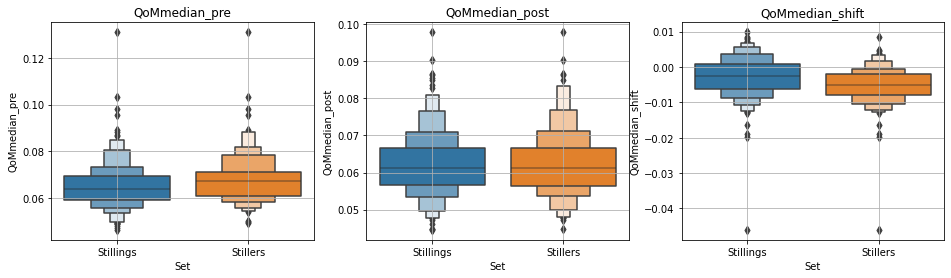

In [283]:
A = Still_times[['QoMmedian_pre', 'QoMmedian_post','QoMmedian_shift']].copy()
A.loc[:,'Set'] = 'Stillings'
B = Part_times[['QoMmedian_pre', 'QoMmedian_post','QoMmedian_shift']].copy()
B.loc[:,'Set'] = 'Stillers'
C = pd.concat([A,B])

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))
tg = 'QoMmedian_pre'
ax = ax1
sns.boxenplot(x = 'Set',y = tg,data = C, ax = ax)
ax.set_title(tg)
#ax2.set_ylim([0,0.25])
ax.grid()
aov = pg.welch_anova(dv=tg,between = 'Set',data=C)
print(aov)

tg = 'QoMmedian_post'
ax = ax2
sns.boxenplot(x = 'Set',y = tg,data = C, ax = ax)
ax.set_title(tg)
#ax2.set_ylim([0,0.25])
ax.grid()
aov = pg.welch_anova(dv=tg,between = 'Set',data=C)
print(aov)


tg = 'QoMmedian_shift'
ax = ax3
sns.boxenplot(x = 'Set',y = tg,data = C, ax = ax)
ax.set_title(tg)
#ax2.set_ylim([0,0.25])
ax.grid()
aov = pg.welch_anova(dv=tg,between = 'Set',data=C)
print(aov)


plt.show()
#plt.savefig('./Plots/body_move_A_R_qom_less.png',dpi = 300)

In [387]:
medianQM.rolling(10).mean()

57.4           NaN
57.5           NaN
57.6           NaN
57.7           NaN
57.8           NaN
            ...   
8041.8    0.095674
8041.9    0.096487
8042.0    0.096487
8042.1    0.096487
8042.2    0.099244
Length: 50630, dtype: float64

In [386]:
mus_df.rolling(10).mean().median(axis=1)

57.4           NaN
57.5           NaN
57.6           NaN
57.7           NaN
57.8           NaN
            ...   
8041.8    0.098922
8041.9    0.098895
8042.0    0.103592
8042.1    0.107599
8042.2    0.128514
Length: 50630, dtype: float64

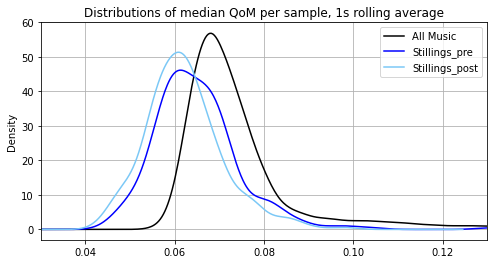

In [377]:
#medianQM = mus_df.median(axis=1)
medianQM_Roll = mus_df.rolling(10).mean().median(axis=1)
f, ax = plt.subplots(1,1,figsize=[8,4])
#medianQM.plot.kde(label='All Music_rough',ax=ax)
medianQM_Roll.plot.kde(label='All Music',color='black',ax=ax)
Still_times.loc[:,'QoMmedian_pre'].plot.kde(label='Stillings_pre',color='blue',ax=ax)
Still_times.loc[:,'QoMmedian_post'].plot.kde(label='Stillings_post',color='xkcd:lightblue',ax=ax)
# Part_times.loc[:,'QoMmedian_pre'].plot.kde(label='Stillers_pre',color='red',ax=ax)
# Part_times.loc[:,'QoMmedian_post'].plot.kde(label='Stillers_post',color='xkcd:pink',ax=ax)

plt.legend()
plt.title('Distributions of median QoM per sample, 1s rolling average')
plt.grid()
#Part_Still.loc[:,'Ratio'].plot.kde()
plt.xlim([0.03,0.13])
plt.ylim([-3,60])
plt.savefig('./Plots/All_Stillings_medQoM_dke.png',dpi = 300)

plt.show()

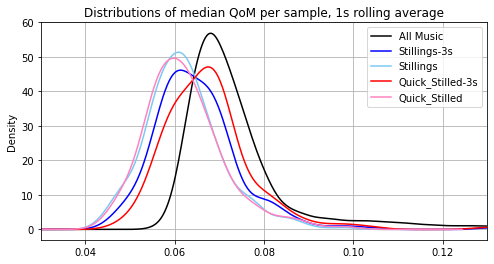

In [379]:
#medianQM = mus_df.median(axis=1)
medianQM_Roll = mus_df.rolling(10).mean().median(axis=1)
f, ax = plt.subplots(1,1,figsize=[8,4])
#medianQM.plot.kde(label='All Music_rough',ax=ax)
medianQM_Roll.plot.kde(label='All Music',color='black',ax=ax)
Still_times.loc[:,'QoMmedian_pre'].plot.kde(label='Stillings-3s',color='blue',ax=ax)
Still_times.loc[:,'QoMmedian_post'].plot.kde(label='Stillings',color='xkcd:lightblue',ax=ax)
Part_times.loc[:,'QoMmedian_pre'].plot.kde(label='Quick_Stilled-3s',color='red',ax=ax)
Part_times.loc[:,'QoMmedian_post'].plot.kde(label='Quick_Stilled',color='xkcd:pink',ax=ax)

plt.legend()
plt.title('Distributions of median QoM per sample, 1s rolling average')
plt.grid()
#Part_Still.loc[:,'Ratio'].plot.kde()
plt.xlim([0.03,0.13])
plt.ylim([-3,60])
plt.savefig('./Plots/All_Stillings_Stillers_medQoM_dke.png',dpi = 300)

plt.show()

This difference in distributions shwo that a big part of what is getting excluded here are moments with low starting median QoM, and this low is very low considering the usual motion across all the music sections. 

This also suggests the low end of the stilling pattern is in the noise floor of our measurements or of their stilling behaviour. As low as they can go, reliably.

A new *inclusion* criteria could be a starting QoM (QoMmedian_pre) below the median QoMmedian_post for the Stiller moments. 



In [278]:
Already_still_Thresh = Part_times.loc[:,'QoMmedian_post'].median()
Stillers = Still_times.loc[Still_times['Ratio']>=0.5,:].copy()
Stilled = Still_times.loc[Still_times['Ratio']<0.5,:].copy()
Stilled = Stilled.loc[Stilled['QoMmedian_pre']<=Already_still_Thresh,:]
Stilled = Stilled.loc[Stilled['QoMmedian_post']<=Already_still_Thresh,:]
print([len(Stilled),len(Stillers)])

[49, 125]


In [366]:
Still_times.loc[:,'Criterion'] = 'Select'
Stillers.loc[:,'Criterion'] = '0.5Dec'
Stilled.loc[:,'Criterion'] = 'LowLow'
Mixed_Still = pd.concat([Stillers,Stilled], axis=0).sort_index()

In [280]:
Mixed_Still

,LABEL,Set,Movement,Moment,Since,Type,end,Sequence,Rest,Gap,...,OnsetRate_post,OnsetRate_shift,QoMmean_pre,QoMmean_post,QoMmean_shift,QoMmedian_pre,QoMmedian_post,QoMmedian_shift,Music,Criterion
TIME,,,,,,,,,,,,,,,,,,,,,
65.837000,4.5,1,1,2,4.52,Rest_beat,0.0,0.0,1,0,...,0.164,-0.064,0.093719,0.076876,-0.016842,0.065231,0.061526,-0.003705,Beethoven,0.5Dec
79.016000,10.25,1,1,3,13.18,Rest_beat,0.0,0.0,1,0,...,0.076,-0.412,0.095983,0.080000,-0.015983,0.071701,0.066231,-0.005470,Beethoven,0.5Dec
88.746667,13,1,1,4,9.24,Low_onset,0.0,0.0,0,0,...,0.140,-0.032,0.084274,0.074454,-0.009820,0.067403,0.065510,-0.001893,Beethoven,0.5Dec
115.285333,27.5,1,1,7,3.70,2nd in sequence,0.0,1.0,0,0,...,0.232,-0.008,0.078753,0.085918,0.007165,0.060767,0.064161,0.003394,Beethoven,0.5Dec
133.376000,37,1,1,9,14.64,Low_onset,0.0,0.0,0,0,...,0.284,-0.148,0.086050,0.087047,0.000997,0.071617,0.070155,-0.001461,Beethoven,0.5Dec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7527.613333,e,7,1,239,8.27,Low_Rest,0.0,0.0,1,1,...,0.000,-0.012,0.064628,0.067973,0.003345,0.049775,0.044851,-0.004924,Folk,LowLow
7660.992000,New Point,8,1,241,72.02,Low_Rest,0.0,0.0,0,0,...,0.056,-0.160,0.073157,0.083310,0.010152,0.056886,0.059627,0.002741,Folk,LowLow
7711.690000,New Point,8,1,242,51.20,Low_Rest,0.0,0.0,0,1,...,0.132,-0.192,0.079031,0.069181,-0.009850,0.056553,0.055676,-0.000877,Folk,LowLow


In [368]:
Mixed_Still['Criterion'].to_csv('Mixed_Still.csv')
Stilled['Criterion'].to_csv('Lowlow.csv')
Stillers['Criterion'].to_csv('Dec0p5.csv')
Still_times['Criterion'].to_csv('Stilling_Points.csv')


In [282]:
len(Mixed_Still.index.unique())

174